In [ ]:
# 1
!pip install -q kaggle tensorflow opencv-python scikit-learn matplotlib seaborn pandas
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [ ]:
# 2
!pip install -q kagglehub

import kagglehub
import os


data_dir = kagglehub.dataset_download('briscdataset/brisc2025')

data_dir = os.path.join(data_dir, 'brisc2025')

print("Dataset downloaded to:", data_dir)
print("\nContents of downloaded folder:")
print(os.listdir(data_dir))

Using Colab cache for faster access to the 'brisc2025' dataset.
Dataset downloaded to: /kaggle/input/brisc2025/brisc2025

Contents of downloaded folder:
['manifest.json', 'README.md', 'segmentation_task', 'classification_task', 'manifest.csv', 'manifest.json.sha256', 'manifest.csv.sha256']


In [ ]:
# 3
import os

root_dir = data_dir

print("Full structure:")
for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/ ({len(files)} files, {len(dirs)} subdirs)")

Full structure:
brisc2025/ (5 files, 2 subdirs)
    segmentation_task/ (0 files, 2 subdirs)
        test/ (0 files, 2 subdirs)
            images/ (860 files, 0 subdirs)
            masks/ (860 files, 0 subdirs)
        train/ (0 files, 2 subdirs)
            images/ (3933 files, 0 subdirs)
            masks/ (3933 files, 0 subdirs)
    classification_task/ (0 files, 2 subdirs)
        test/ (0 files, 4 subdirs)
            pituitary/ (300 files, 0 subdirs)
            no_tumor/ (140 files, 0 subdirs)
            meningioma/ (306 files, 0 subdirs)
            glioma/ (254 files, 0 subdirs)
        train/ (0 files, 4 subdirs)
            pituitary/ (1457 files, 0 subdirs)
            no_tumor/ (1067 files, 0 subdirs)
            meningioma/ (1329 files, 0 subdirs)
            glioma/ (1147 files, 0 subdirs)


In [ ]:
# 4
import os
from glob import glob
import numpy as np
import re  # for label extraction

classes = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
label_map = {cls: idx for idx, cls in enumerate(classes)}

def extract_label_from_filename(filename):
    name = os.path.basename(filename).lower()
    if '_gl_' in name:
        return label_map['glioma']
    elif '_me_' in name:
        return label_map['meningioma']
    elif '_pi_' in name:
        return label_map['pituitary']
    return -1

def get_seg_paths(split='train'):
    img_dir = os.path.join(data_dir, 'segmentation_task', split, 'images')
    msk_dir = os.path.join(data_dir, 'segmentation_task', split, 'masks')

    if not os.path.exists(img_dir) or not os.path.exists(msk_dir):
        raise ValueError(f"{split} folders not found! Check path: {img_dir}")


    image_paths = sorted(glob(os.path.join(img_dir, '*.*')))


    mask_paths = []
    labels = []
    missing_masks = 0

    for img_path in image_paths:
        basename = os.path.basename(img_path)
        # Find mask with same name
        possible_masks = glob(os.path.join(msk_dir, os.path.splitext(basename)[0] + '.*'))
        if possible_masks:
            mask_paths.append(possible_masks[0])  # first match
        else:
            missing_masks += 1
            continue

        label = extract_label_from_filename(basename)
        if label == -1:
            print(f"Warning: Could not extract label from {basename}")
        labels.append(label)

    if missing_masks > 0:
        print(f"Warning: {missing_masks} images without matching masks in {split}")

    return image_paths, mask_paths, np.array(labels)

# Load train and test from segmentation_task
train_img_paths, train_msk_paths, train_labels = get_seg_paths('train')
test_img_paths,  test_msk_paths,  test_labels  = get_seg_paths('test')

print(f"Training: {len(train_img_paths)} images, {len(train_msk_paths)} masks")
print(f"Testing : {len(test_img_paths)} images, {len(test_msk_paths)} masks")

# Quick check on label distribution
unique, counts = np.unique(train_labels, return_counts=True)
print("Train label counts:", dict(zip([classes[i] if i>=0 else 'unknown' for i in unique], counts)))

Training: 3933 images, 3933 masks
Testing : 860 images, 860 masks
Train label counts: {'glioma': np.int64(1147), 'meningioma': np.int64(1329), 'pituitary': np.int64(1457)}


In [ ]:
# preprocessing images and masks
IMG_SIZE = (256, 256)

def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return img.astype(np.float32)

def preprocess_mask(path):
    msk = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.resize(msk, IMG_SIZE)
    msk = (msk > 0).astype(np.float32)  # Binary: tumor if >0
    return msk


def load_data(img_paths, msk_paths, labels):
    images = np.array([preprocess_image(p) for p in img_paths])
    masks = np.array([preprocess_mask(p) for p in msk_paths])
    labels = np.array(labels)
    images = np.expand_dims(images, -1)  # channel dimension
    masks = np.expand_dims(masks, -1)
    return images, masks, labels

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [ ]:
# Load train data and split into train/validation sets
train_images, train_masks, train_labels_arr = load_data(train_img_paths, train_msk_paths, train_labels)
X_train, X_val, y_train_seg, y_val_seg, y_train_cls, y_val_cls = train_test_split(
    train_images, train_masks, train_labels_arr, test_size=0.2, stratify=train_labels_arr, random_state=42
)


X_test, y_test_seg, y_test_cls = load_data(test_img_paths, test_msk_paths, test_labels)

print(f"Data loaded and split into:")
print(f"  Train images: {X_train.shape}, masks: {y_train_seg.shape}, labels: {y_train_cls.shape}")
print(f"  Validation images: {X_val.shape}, masks: {y_val_seg.shape}, labels: {y_val_cls.shape}")
print(f"  Test images: {X_test.shape}, masks: {y_test_seg.shape}, labels: {y_test_cls.shape}")

Data loaded and split into:
  Train images: (3146, 256, 256, 1), masks: (3146, 256, 256, 1), labels: (3146,)
  Validation images: (787, 256, 256, 1), masks: (787, 256, 256, 1), labels: (787,)
  Test images: (860, 256, 256, 1), masks: (860, 256, 256, 1), labels: (860,)


**Dataset Overview & Statistics**

In [ ]:
print("=== Dataset Summary ===")
print(f"Total training images/masks: {len(train_img_paths)}")
print(f"Total testing images/masks : {len(test_img_paths)}")
print(f"Image shape after preprocessing: {X_train[0].shape}")
print(f"Mask shape after preprocessing : {y_train_seg[0].shape}")
print(f"Number of classes: {len(classes)} → {classes}")

print("\nClass distribution (from labels extracted from filenames):")
train_class_counts = pd.Series([classes[l] for l in train_labels]).value_counts().sort_index()
test_class_counts = pd.Series([classes[l] for l in test_labels]).value_counts().sort_index()

dist_df = pd.DataFrame({'Train': train_class_counts, 'Test': test_class_counts}).fillna(0).astype(int)
display(dist_df)


print("\nPercentage distribution:")
display((dist_df / dist_df.sum() * 100).round(2))

=== Dataset Summary ===
Total training images/masks: 3933
Total testing images/masks : 860
Image shape after preprocessing: (256, 256, 1)
Mask shape after preprocessing : (256, 256, 1)
Number of classes: 4 → ['glioma', 'meningioma', 'pituitary', 'no_tumor']

Class distribution (from labels extracted from filenames):


,Train,Test
glioma,1147,254
meningioma,1329,306
pituitary,1457,300



Percentage distribution:


,Train,Test
glioma,29.16,29.53
meningioma,33.79,35.58
pituitary,37.05,34.88


**Tumor Presence Statistics**

In [ ]:
def has_tumor(mask):
    return np.max(mask) > 0.5

train_tumor_ratio = np.mean([has_tumor(m) for m in y_train_seg])
val_tumor_ratio   = np.mean([has_tumor(m) for m in y_val_seg])
test_tumor_ratio  = np.mean([has_tumor(m) for m in y_test_seg])

print("=== Tumor Presence (No Tumor vs Has Tumor) ===")
tumor_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Samples with Tumor': [
        int(train_tumor_ratio * len(y_train_seg)),
        int(val_tumor_ratio * len(y_val_seg)),
        int(test_tumor_ratio * len(y_test_seg))
    ],
    'Samples without Tumor': [
        len(y_train_seg) - int(train_tumor_ratio * len(y_train_seg)),
        len(y_val_seg) - int(val_tumor_ratio * len(y_val_seg)),
        len(y_test_seg) - int(test_tumor_ratio * len(y_test_seg))
    ],
    '% with Tumor': [train_tumor_ratio*100, val_tumor_ratio*100, test_tumor_ratio*100]
}).round(2)

display(tumor_df)

=== Tumor Presence (No Tumor vs Has Tumor) ===


,Set,Samples with Tumor,Samples without Tumor,% with Tumor
0,Train,3146,0,100.0
1,Validation,787,0,100.0
2,Test,860,0,100.0


**Visualize Samples from Each Class**

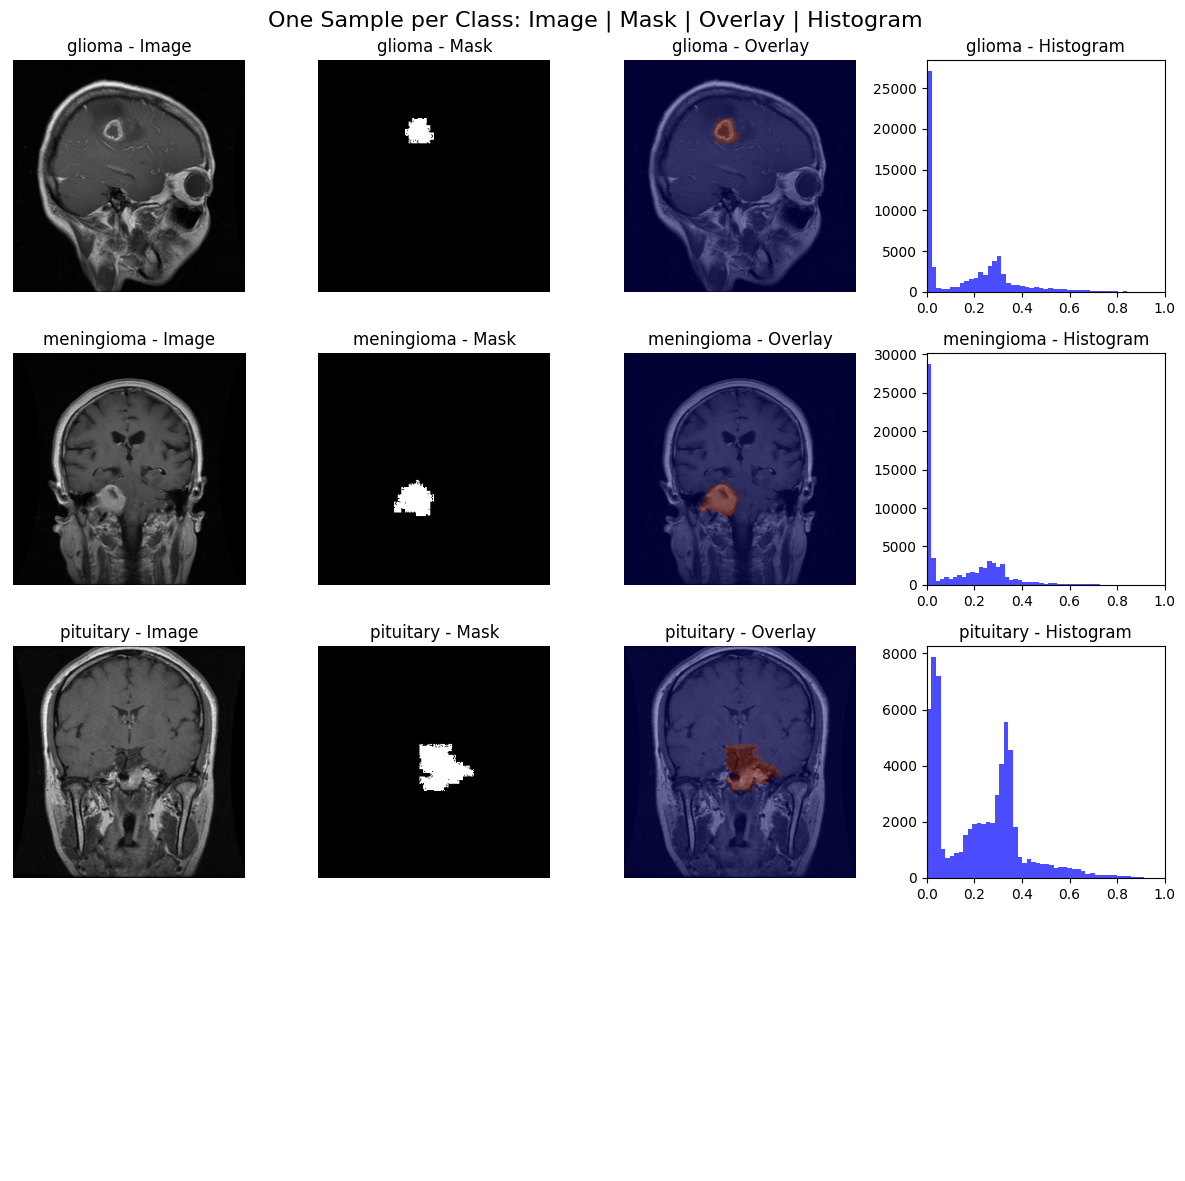

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

present_classes = np.unique(y_train_cls) # Get unique class indices present in y_train_cls

for plot_idx, cls_idx in enumerate(present_classes):
    # Pick one random image from this
    idx = np.random.choice(np.where(y_train_cls == cls_idx)[0])
    img = X_train[idx].squeeze()
    msk = y_train_seg[idx].squeeze()
    cls_name = classes[cls_idx]

    axes[plot_idx * 4].imshow(img, cmap='gray')
    axes[plot_idx * 4].set_title(f'{cls_name} - Image')
    axes[plot_idx * 4].axis('off')

    axes[plot_idx * 4 + 1].imshow(msk, cmap='gray')
    axes[plot_idx * 4 + 1].set_title(f'{cls_name} - Mask')
    axes[plot_idx * 4 + 1].axis('off')

    axes[plot_idx * 4 + 2].imshow(img, cmap='gray')
    axes[plot_idx * 4 + 2].imshow(msk, cmap='jet', alpha=0.4)
    axes[plot_idx * 4 + 2].set_title(f'{cls_name} - Overlay')
    axes[plot_idx * 4 + 2].axis('off')

    # Intensity histogram
    axes[plot_idx * 4 + 3].hist(img.ravel(), bins=50, color='blue', alpha=0.7)
    axes[plot_idx * 4 + 3].set_title(f'{cls_name} - Histogram')
    axes[plot_idx * 4 + 3].set_xlim(0, 1)

# Turn off any unused subplots if < 4
for i in range(len(present_classes) * 4, len(axes)):
    axes[i].axis('off')

plt.suptitle("One Sample per Class: Image | Mask | Overlay | Histogram", fontsize=16)
plt.tight_layout()
plt.show()

**Tumor Size Distribution**

/tmp/ipython-input-661153970.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Train', 'Val', 'Test'])


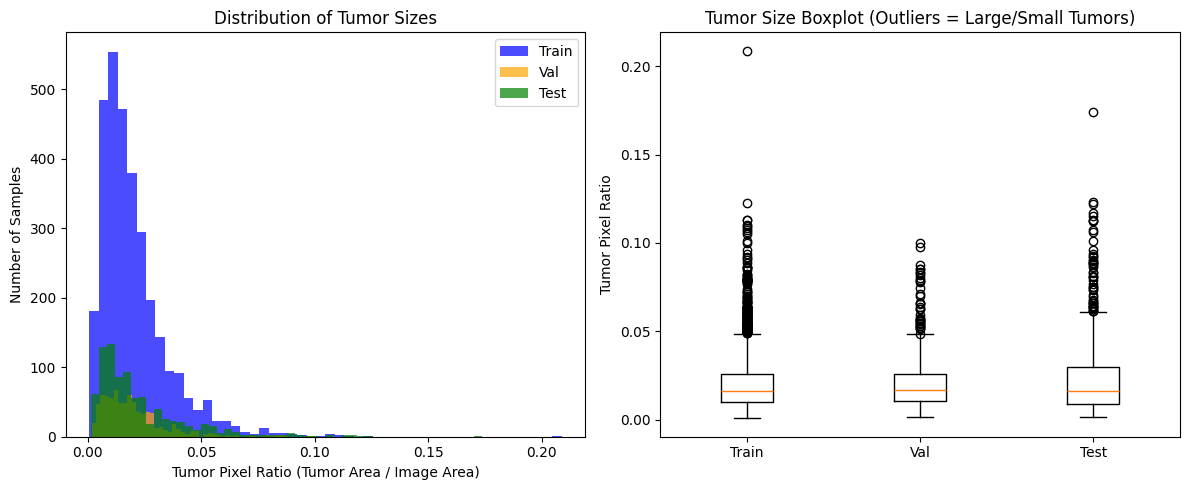

Average tumor pixel ratio (Train): 0.0204
Max tumor ratio: 0.2088 → Very large tumor!
Min tumor ratio (excluding no-tumor): 0.0007


In [ ]:
def tumor_pixel_ratio(mask):
    return np.sum(mask) / mask.size  # Fraction of tumor pixels

tumor_ratios_train = [tumor_pixel_ratio(m) for m in y_train_seg]
tumor_ratios_val   = [tumor_pixel_ratio(m) for m in y_val_seg]
tumor_ratios_test  = [tumor_pixel_ratio(m) for m in y_test_seg]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(tumor_ratios_train, bins=50, alpha=0.7, label='Train', color='blue')
plt.hist(tumor_ratios_val, bins=50, alpha=0.7, label='Val', color='orange')
plt.hist(tumor_ratios_test, bins=50, alpha=0.7, label='Test', color='green')
plt.xlabel('Tumor Pixel Ratio (Tumor Area / Image Area)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Tumor Sizes')
plt.legend()

plt.subplot(1, 2, 2)
data = [tumor_ratios_train, tumor_ratios_val, tumor_ratios_test]
plt.boxplot(data, labels=['Train', 'Val', 'Test'])
plt.ylabel('Tumor Pixel Ratio')
plt.title('Tumor Size Boxplot (Outliers = Large/Small Tumors)')

plt.tight_layout()
plt.show()

print(f"Average tumor pixel ratio (Train): {np.mean(tumor_ratios_train):.4f}")
print(f"Max tumor ratio: {np.max(tumor_ratios_train):.4f} → Very large tumor!")
print(f"Min tumor ratio (excluding no-tumor): {np.min([r for r in tumor_ratios_train if r > 0]):.4f}")

**Intensity Distribution Across Classes**

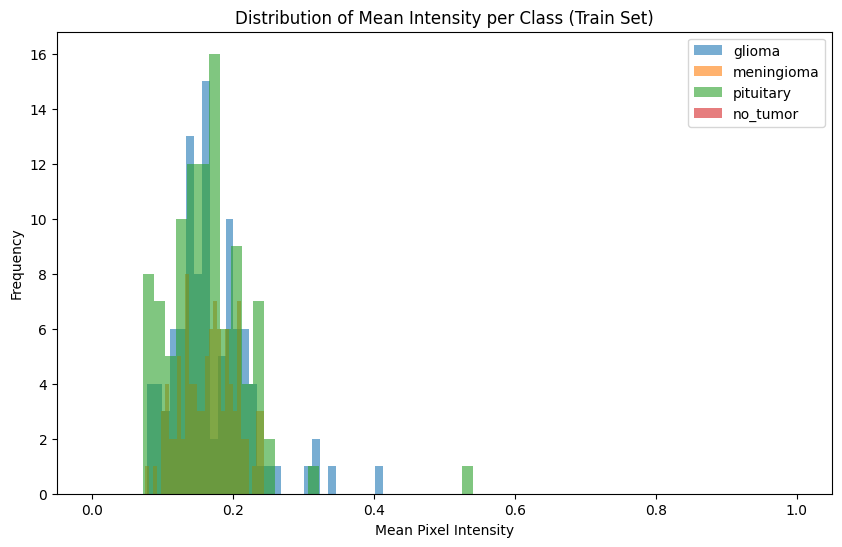

In [ ]:
plt.figure(figsize=(10, 6))
for i, cls in enumerate(classes):
    cls_indices = np.where(train_labels == i)[0]
    sample_imgs = X_train[cls_indices[:100]]  # 100 per class to avoid overload
    mean_intensities = [np.mean(img) for img in sample_imgs]
    plt.hist(mean_intensities, bins=30, alpha=0.6, label=cls)

plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Intensity per Class (Train Set)')
plt.legend()
plt.show()

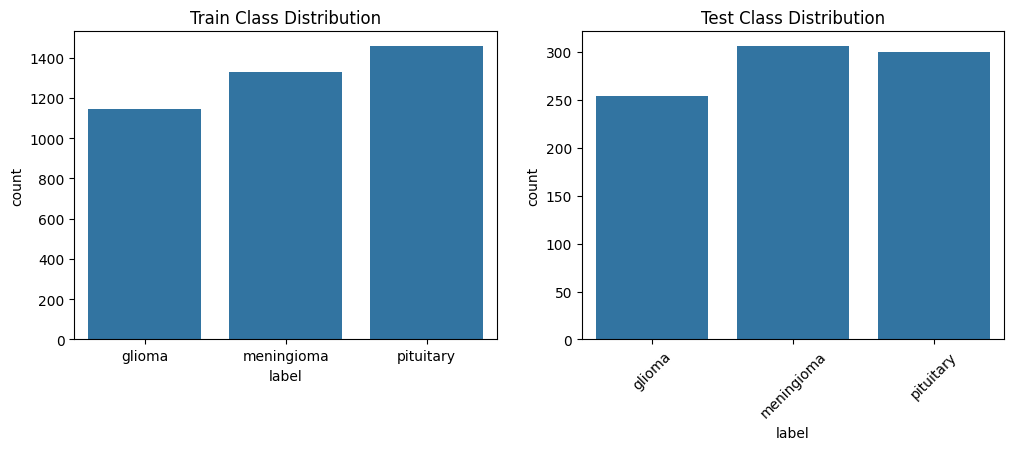

In [ ]:
# 5
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.DataFrame({'label': [classes[l] if l >=0 else 'unknown' for l in train_labels]})
test_df = pd.DataFrame({'label': [classes[l] if l >=0 else 'unknown' for l in test_labels]})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='label', data=train_df, ax=axes[0])
axes[0].set_title('Train Class Distribution')
sns.countplot(x='label', data=test_df, ax=axes[1])
axes[1].set_title('Test Class Distribution')
plt.xticks(rotation=45)
plt.show()

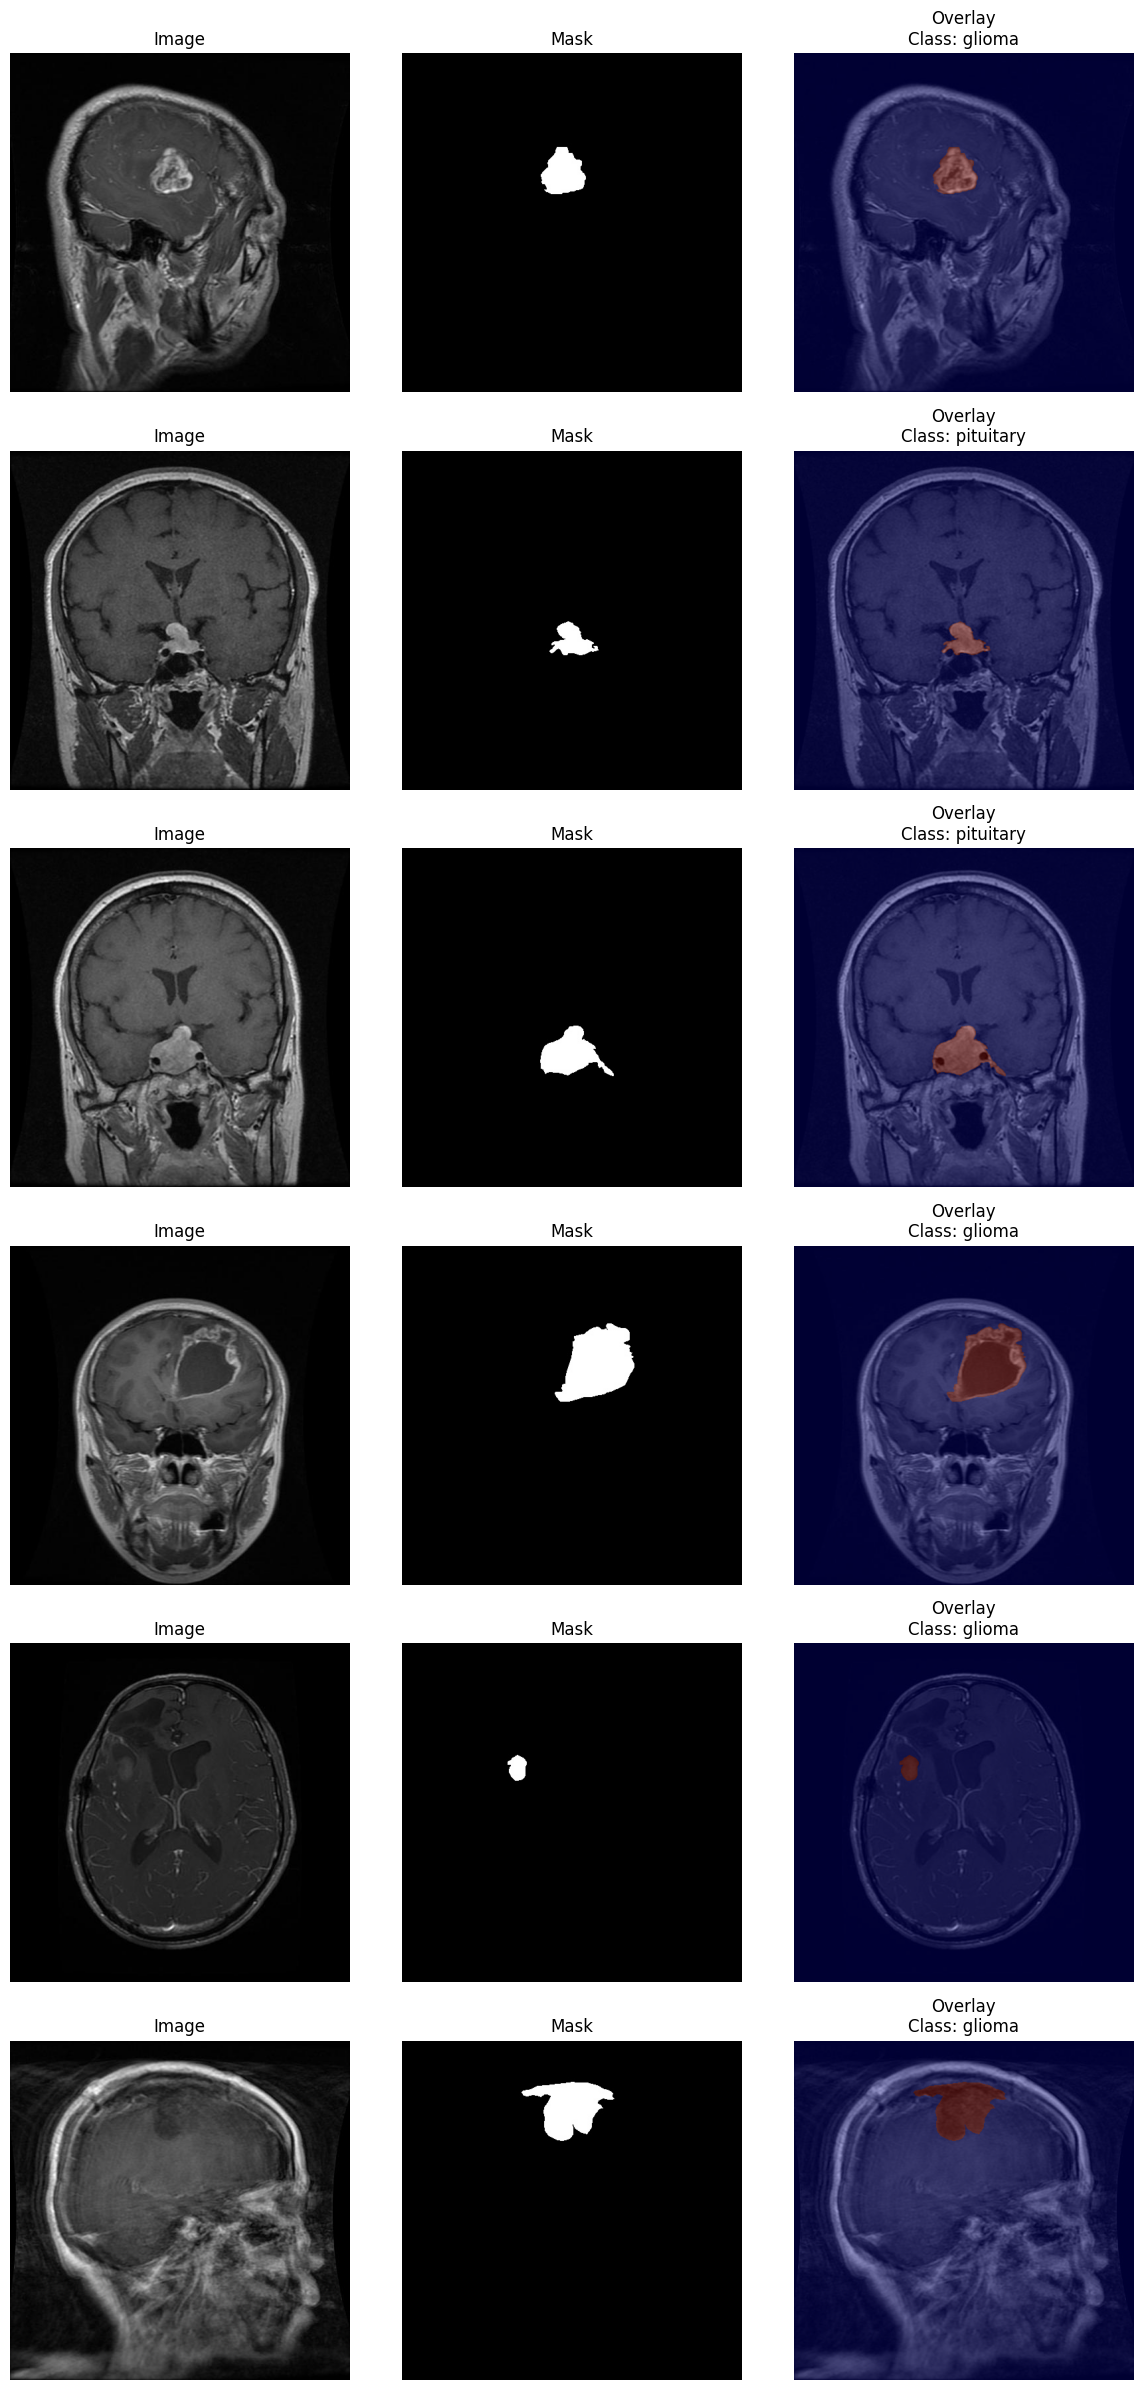

In [ ]:
# 6
import cv2

def show_samples(img_paths, msk_paths, labels, n=6):
    idxs = np.random.choice(len(img_paths), n, replace=False)
    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
    for i, idx in enumerate(idxs):
        img = cv2.imread(img_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = cv2.imread(msk_paths[idx], 0)

        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title('Image')
        axes[i, 1].imshow(msk, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 2].imshow(img_rgb)
        axes[i, 2].imshow(msk, cmap='jet', alpha=0.4)
        axes[i, 2].set_title(f'Overlay\nClass: {classes[labels[idx]]}')
        for ax in axes[i]: ax.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_img_paths, train_msk_paths, train_labels)

Sample sizes: {(512, 512)}


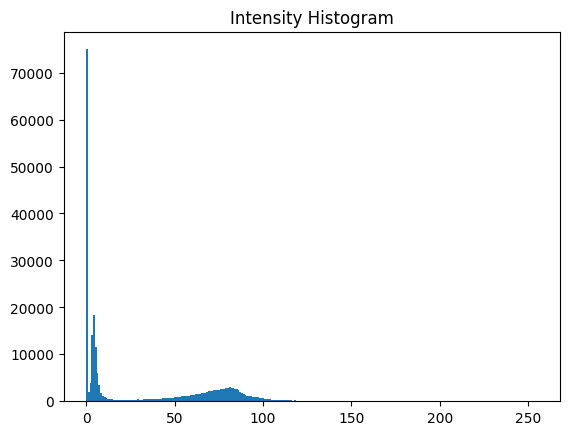

Mask unique values: [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]


In [ ]:
# 7
sizes = [cv2.imread(p).shape[:2] for p in train_img_paths[:100]]  # Sample 100
print("Sample sizes:", set(sizes))

# Intensity histogram
img_sample = cv2.imread(train_img_paths[0], 0)
plt.hist(img_sample.ravel(), bins=256)
plt.title('Intensity Histogram')
plt.show()

# For masks
msk_sample = cv2.imread(train_msk_paths[0], 0)
unique = np.unique(msk_sample)
print("Mask unique values:", unique)